# Fokker-Planck 2D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

> $\partial_t \rho=\nabla \cdot\left(\mathcal{M} \nabla \frac{\rho}{\mathcal{M}}\right)$, for  $t > 0$, $(x,y) \in \Omega=(-3,3) \times(-3,3)$.

> $u(0, x)=u^0(x), \quad x \in \Omega=(-3,3) \times(-3,3)$

> $\left.\nabla \frac{\rho}{\mathcal{M}} \cdot \mathbf{n}\right|_{\partial \Omega}=0, \quad t \geq 0 .$


where $\mathcal{M}:=e^{-\frac{x^2+y^2}{2}}$

## Libraries

In [1]:
# Import packages
import sys
sys.path.append('/home/juanfelipe/Desktop/research/kinetick/source')
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error
from jax import clear_caches
import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
from numpy.linalg import norm
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster
clear_caches()

## Utils

In [2]:
def Kphiphi_assembly(Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian2D
  if k == 'Matern52':
    kernel = Matern_Kernel_52_2D

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mbdry4 = int(Xboundary.shape[0]/4)
  M = Momega + Mboundary

  # Boundaries
  Xboundarybottom = Xboundary[:Mbdry4,:]
  Xboundaryright = Xboundary[Mbdry4:2*Mbdry4,:]
  Xboundarytop = Xboundary[2*Mbdry4:3*Mbdry4,:]
  Xboundaryleft = Xboundary[3*Mbdry4:4*Mbdry4,:]

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val1 = K_2D(kernel, Xomega, Xomega, k_param) # K(X,X)
  val2 = partial_MtimesPartialx_2D(Xomega, Xomega, kernel, k_param)
  val3 = partial_MtimesPartialy_2D(Xomega, Xomega, kernel, k_param)
  val4 = big_term2D(Xomega, Xomega, kernel, k_param)
  val = val1 - h*val2 - h*val3 + (h**2)*val4  
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val1 = first_term_12(Xomega, Xboundarybottom, kernel, k_param)
  val2 = second_term12(Xomega, Xboundarybottom, kernel, k_param)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, Momega:Momega + Mbdry4].set(val)
  Theta = Theta.at[Momega:Momega + Mbdry4, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 1,3
  val1 = first_term_13(Xomega, Xboundaryright, kernel, k_param)
  val2 = second_term13(Xomega, Xboundaryright, kernel, k_param)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, Momega + Mbdry4:Momega + 2*Mbdry4].set(val)
  Theta = Theta.at[Momega + Mbdry4:Momega + 2*Mbdry4, :Momega].set(jnp.transpose(val)) # Block 3,1

  # Block 1,4
  val1 = first_term_14(Xomega, Xboundarytop, kernel, k_param)
  val2 = second_term14(Xomega, Xboundarytop, kernel, k_param)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, Momega + 2*Mbdry4:Momega + 3*Mbdry4].set(val)
  Theta = Theta.at[Momega + 2*Mbdry4:Momega + 3*Mbdry4, :Momega].set(jnp.transpose(val)) # Block 4,1

  # Block 1,5
  val1 = first_term_15(Xomega, Xboundaryleft, kernel, k_param)
  val2 = second_term15(Xomega, Xboundaryleft, kernel, k_param)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, Momega + 3*Mbdry4:Momega + 4*Mbdry4].set(val)
  Theta = Theta.at[Momega + 3*Mbdry4:Momega + 4*Mbdry4, :Momega].set(jnp.transpose(val)) # Block 5,1

  # Block 2,2
  val = partialy_nbottom_partialx_nbottom_overMy2D(Xboundarybottom,Xboundarybottom, kernel, k_param)
  Theta = Theta.at[Momega:Momega + Mbdry4, Momega:Momega + Mbdry4].set(val)

  # Block 2,3
  val = partialy_nright_partialx_nbottom_overMy2D(Xboundarybottom,Xboundaryright, kernel, k_param)
  Theta = Theta.at[Momega:Momega + Mbdry4, Momega + Mbdry4:Momega + 2*Mbdry4].set(val)
  Theta = Theta.at[Momega + Mbdry4:Momega + 2*Mbdry4, Momega:Momega + Mbdry4].set(val) # Block 3,2

  # Block 2,4
  val = partialy_ntop_partialx_nbottom_overMy2D(Xboundarybottom,Xboundarytop, kernel, k_param)
  Theta = Theta.at[Momega:Momega + Mbdry4, Momega + 2*Mbdry4:Momega + 3*Mbdry4].set(val)
  Theta = Theta.at[Momega + 2*Mbdry4:Momega + 3*Mbdry4, Momega:Momega + Mbdry4].set(val) # Block 4,2

  # Block 2,5
  val = partialy_nleft_partialx_nbottom_overMy2D(Xboundarybottom,Xboundaryleft, kernel, k_param)
  Theta = Theta.at[Momega:Momega + Mbdry4, Momega + 3*Mbdry4:Momega + 4*Mbdry4].set(val)
  Theta = Theta.at[Momega + 3*Mbdry4:Momega + 4*Mbdry4, Momega:Momega + Mbdry4].set(val) # Block  5,2

  # Block 3,3
  val = partialy_nright_partialx_nright_overMy2D(Xboundaryright,Xboundaryright, kernel, k_param)
  Theta = Theta.at[Momega + Mbdry4:Momega + 2*Mbdry4, Momega + Mbdry4:Momega + 2*Mbdry4].set(val)

  # Block 3,4
  val = partialy_ntop_partialx_nright_overMy2D(Xboundaryright,Xboundarytop, kernel, k_param)
  Theta = Theta.at[Momega + Mbdry4:Momega + 2*Mbdry4, Momega + 2*Mbdry4:Momega + 3*Mbdry4].set(val)
  Theta = Theta.at[Momega + 2*Mbdry4:Momega + 3*Mbdry4, Momega + Mbdry4:Momega + 2*Mbdry4].set(val) # Block 4,3

  # Block 3,5
  val = partialy_nleft_partialx_nright_overMy2D(Xboundaryright,Xboundaryleft, kernel, k_param)
  Theta = Theta.at[Momega + Mbdry4:Momega + 2*Mbdry4, Momega + 3*Mbdry4:Momega + 4*Mbdry4].set(val)
  Theta = Theta.at[Momega + 3*Mbdry4:Momega + 4*Mbdry4, Momega + Mbdry4:Momega + 2*Mbdry4].set(val) # Block 5,3

  # Block 4,4
  val = partialy_ntop_partialx_ntop_overMy2D(Xboundarytop,Xboundarytop, kernel, k_param)
  Theta = Theta.at[Momega + 2*Mbdry4:Momega + 3*Mbdry4, Momega + 2*Mbdry4:Momega + 3*Mbdry4].set(val)

  # Block 4,5
  val = partialy_nleft_partialx_ntop_overMy2D(Xboundarytop,Xboundaryleft, kernel, k_param)
  Theta = Theta.at[Momega + 2*Mbdry4:Momega + 3*Mbdry4, Momega + 3*Mbdry4:Momega + 4*Mbdry4].set(val)
  Theta = Theta.at[Momega + 3*Mbdry4:Momega + 4*Mbdry4, Momega + 2*Mbdry4:Momega + 3*Mbdry4].set(val) # Block 5,4 

  # Block 5,5
  val = partialy_nleft_partialx_nleft_overMy2D(Xboundaryleft,Xboundaryleft, kernel, k_param)
  Theta = Theta.at[Momega + 3*Mbdry4:Momega + 4*Mbdry4, Momega + 3*Mbdry4:Momega + 4*Mbdry4].set(val)
  
  return Theta

In [3]:
def Kphi_assembly(Xtest, Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian2D
  if k == 'Matern52':
    kernel = Matern_Kernel_52_2D

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mbdry4 = int(Xboundary.shape[0]/4)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Boundaries
  Xboundarybottom = Xboundary[:Mbdry4,:]
  Xboundaryright = Xboundary[Mbdry4:2*Mbdry4,:]
  Xboundarytop = Xboundary[2*Mbdry4:3*Mbdry4,:]
  Xboundaryleft = Xboundary[3*Mbdry4:4*Mbdry4,:]

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val1 = K_2D(kernel, Xomega, Xtest, k_param)
  val2 = partial_MtimesPartialx_2D(Xomega, Xtest, kernel, k_param)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = partialx_nbottom_overMx_2D(Xboundarybottom , Xtest, kernel, k_param)
  Theta = Theta.at[Momega:Momega + Mbdry4, :].set(val)

  # Block 3
  val = partialx_nright_overMx_2D(Xboundaryright , Xtest, kernel, k_param)
  Theta = Theta.at[Momega + Mbdry4:Momega + 2*Mbdry4, :].set(val)

  # Block 4
  val = partialx_ntop_overMx_2D(Xboundarytop , Xtest, kernel, k_param)
  Theta = Theta.at[Momega + 2*Mbdry4:Momega + 3*Mbdry4, :].set(val)

  # Block 5
  val = partialx_nleft_overMx_2D(Xboundaryleft , Xtest, kernel, k_param)
  Theta = Theta.at[Momega + 3*Mbdry4:Momega + 4*Mbdry4, :].set(val)

  return Theta

In [4]:
def generate_pts_interior(num_points):
    points = np.random.uniform(low=[-3,-3],high=[3,3],size=[num_points,2])
    return points

def generate_pts_boundary(num_points):
    a = -3
    b = 3
    # Generate random coordinates on the four sides of the unit square
    x = np.concatenate((
        (b - a) * np.random.random(num_points) + a, # points on the bottom side
        b*np.ones(num_points),                      # points on the right side
        (b - a) * np.random.random(num_points) + a, # points on the top side
        a*np.ones(num_points)                       # points on the left side
    ))

    y = np.concatenate((
        a*np.ones(num_points),                       # points on the bottom side
        (b - a) * np.random.random(num_points) + a,  # points on the right side
        b*np.ones(num_points),                       # points on the top side
        (b - a) * np.random.random(num_points) + a   # points on the left side
    ))

    points = np.column_stack((x, y))
    return points

## How far can we go ?

In [5]:
#np.random.seed(7)
# sqrt(M_Omega)
# Momega = 500
# # M - M_Omega 
# Mboundary = 400
# # X_{\partial\Omega}: bottom, right, top, left 
# Xboundary = generate_pts_boundary(int(Mboundary/4)) 
# # X_\Omega
# Xomega = generate_pts_interior(Momega)


x1 = np.linspace(-2.9,2.9,20)
x2 = np.linspace(-2.9,2.9,20)

x1v, x2v = np.meshgrid(x1,x2)

Xomega = np.vstack([x1v.ravel(), x2v.ravel()]).T

nbry = 10
bottom = np.hstack([np.linspace(-3,3,nbry).reshape(-1,1),-3*np.ones([nbry,1])])
right = np.hstack([3*np.ones([nbry,1]),np.linspace(-3,3,nbry).reshape(-1,1)])
top = np.hstack([np.linspace(-3,3,nbry).reshape(-1,1), 3*np.ones([nbry,1])])
left = np.hstack([-3*np.ones([nbry,1]),np.linspace(-3,3,nbry).reshape(-1,1)])

Xboundary = np.vstack([bottom,right,top,left])




# X_full
Xfull = np.vstack((Xomega, Xboundary))
# u(X_\Omega,0)
u0 = fp_2d_u0(Xomega[:,0],Xomega[:,1])
# kernel
kernel = 'Gaussian'
# Kernel lenght-scale
k_param = 0.5
# Time step
h = 1e-5
# Final time - We add 0.1 since that is the initial condition
final_t = 0.1 + h
# nugget
nugget = 1e-8

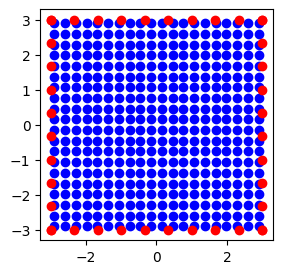

In [15]:
plt.figure(figsize=(3,3))
plt.scatter(Xomega[:,0],Xomega[:,1], c='blue')
plt.scatter(Xboundary[:,0],Xboundary[:,1], c='red')
plt.show()

Build `Kphiphi`

In [7]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)

Build `y_prev`

In [8]:
y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [9]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
#sol = jnp.linalg.solve(Kphiphi,y_prev)

Get `K(Xtest,Xfull)`

In [10]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)

In [11]:
u_next = np.dot(Kphi.T,sol)

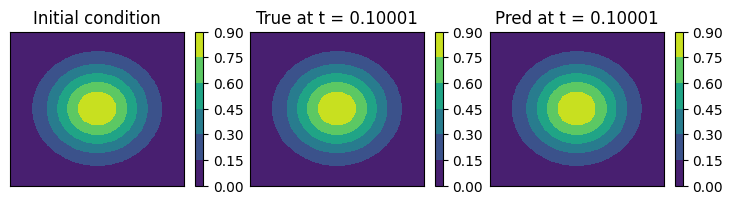

In [12]:
fig, axs = plt.subplots(figsize = (9,2), nrows = 1, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
# fig.suptitle('t=0.1 | true at t= {} | pred at t={}'.format(final_t,final_t))
# Initial condition
axs0 = axs[0].tricontourf(Xfull[:,0],Xfull[:,1],fp_2d_u0(Xfull[:,0],Xfull[:,1]))
axs[0].title.set_text('Initial condition')
plt.colorbar(axs0, ax = axs[0])
# True next
axs1 = axs[1].tricontourf(Xfull[:,0],Xfull[:,1],fp_2d_sol(final_t, Xfull[:,0],Xfull[:,1]))
axs[1].title.set_text('True at t = {}'.format(final_t))
plt.colorbar(axs1, ax = axs[1])
# Predicted next
axs2 = axs[2].tricontourf(Xfull[:,0],Xfull[:,1],u_next)
axs[2].title.set_text('Pred at t = {}'.format(final_t))
plt.colorbar(axs2, ax = axs[2])
# Plot settings
for i in range(3):
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
#nmse = mean_squared_error(u_next,fp_1d_sol(final_t, Xfull))/mean_squared_error(0*fp_1d_sol(final_t, Xfull),fp_1d_sol(final_t, Xfull))
plt.show()

In [13]:
true = fp_2d_sol(final_t, Xfull[:,0],Xfull[:,1])
pred = u_next
rrmse = rel_mse(true, pred, root = True)
print('Relative MSE: {}'.format(rrmse))

Relative MSE: 0.0009543556225367206


## Let's take small steps 

In [17]:
clear_caches()
final_t = 0.5
masses = []
steps = int((final_t-0.1)//h)
#delta = Xfull[1]-Xfull[0]
# Initialize at the initial condition
uprev = u0
for _ in range(steps):
    y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
    sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
    #sol = jnp.linalg.solve(Kphiphi, y_prev)
    u_next = np.dot(Kphi.T,sol)
    #mass = trap(u_next,delta)
    #masses.append(mass)
    # update
    uprev = u_next[:Xomega.shape[0]]
    print(u_next[[0,10,15]])

[0.00197318 0.04127305 0.01497981]
[0.00197298 0.04127117 0.01497904]
[0.00197277 0.04126929 0.01497827]
[0.00197257 0.04126741 0.0149775 ]
[0.00197237 0.04126553 0.01497673]
[0.00197216 0.04126365 0.01497596]
[0.00197196 0.04126177 0.0149752 ]
[0.00197175 0.04125989 0.01497443]
[0.00197155 0.04125801 0.01497366]
[0.00197135 0.04125613 0.01497289]
[0.00197114 0.04125426 0.01497213]
[0.00197094 0.04125238 0.01497136]
[0.00197074 0.0412505  0.01497059]
[0.00197053 0.04124863 0.01496982]
[0.00197033 0.04124675 0.01496906]
[0.00197013 0.04124488 0.01496829]
[0.00196993 0.041243   0.01496753]
[0.00196972 0.04124113 0.01496676]
[0.00196952 0.04123925 0.01496599]
[0.00196932 0.04123738 0.01496523]
[0.00196912 0.04123551 0.01496446]
[0.00196892 0.04123364 0.0149637 ]
[0.00196871 0.04123176 0.01496293]
[0.00196851 0.04122989 0.01496217]
[0.00196831 0.04122802 0.0149614 ]
[0.00196811 0.04122615 0.01496064]
[0.00196791 0.04122428 0.01495988]
[0.00196771 0.04122241 0.01495911]
[0.00196751 0.041220

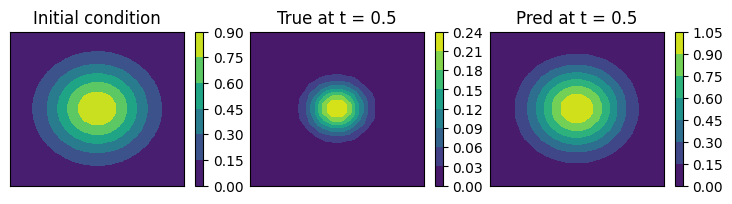

In [18]:
fig, axs = plt.subplots(figsize = (9,2), nrows = 1, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
# fig.suptitle('t=0.1 | true at t= {} | pred at t={}'.format(final_t,final_t))
# Initial condition
axs0 = axs[0].tricontourf(Xfull[:,0],Xfull[:,1],fp_2d_u0(Xfull[:,0],Xfull[:,1]))
axs[0].title.set_text('Initial condition')
plt.colorbar(axs0, ax = axs[0])
# True next
axs1 = axs[1].tricontourf(Xfull[:,0],Xfull[:,1],fp_2d_sol(final_t, Xfull[:,0],Xfull[:,1]))
axs[1].title.set_text('True at t = {}'.format(final_t))
plt.colorbar(axs1, ax = axs[1])
# Predicted next
axs2 = axs[2].tricontourf(Xfull[:,0],Xfull[:,1],u_next)
axs[2].title.set_text('Pred at t = {}'.format(final_t))
plt.colorbar(axs2, ax = axs[2])
# Plot settings
for i in range(3):
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
#nmse = mean_squared_error(u_next,fp_1d_sol(final_t, Xfull))/mean_squared_error(0*fp_1d_sol(final_t, Xfull),fp_1d_sol(final_t, Xfull))
plt.show()

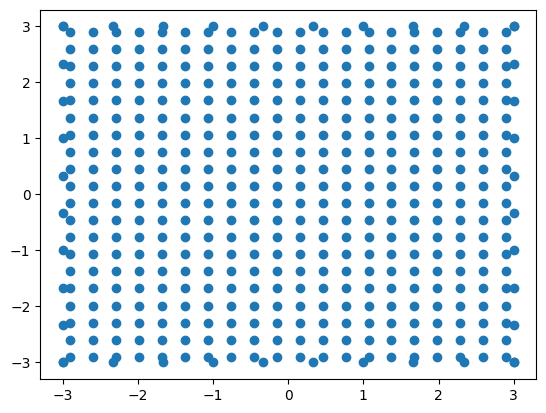

In [18]:
plt.scatter(Xfull[:,0],Xfull[:,1])

In [ ]:
plt.figure()
# Initial condition
plt.plot(Xfull,fp_1d_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,fp_1d_sol(final_t, Xfull),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,fp_1d_sol(final_t, Xfull))/mean_squared_error(0*fp_1d_sol(final_t, Xfull),fp_1d_sol(final_t, Xfull))
plt.title('final_t = {}, $\Delta t = ${} | Normalized MSE:{}'.format(final_t, h, round(nmse,7)))
plt.legend()
plt.show()

### Mass conservation

In [ ]:
masses[-1]

In [ ]:
t_s = np.arange(0.1, final_t, h)[1:]
plt.figure()
# masses per time
plt.plot(t_s,masses,'.-',)
plt.ylim([0,2])
plt.title('final_t = {}, $\Delta t = ${} '.format(final_t, h))
plt.legend()
plt.show()

## Convergence

In [ ]:
nugget = 0.

### Experiment 1

- $h = $`1e-1`
- `final_t`$ = 2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [ ]:
# Experiment 1.1 - L2-norms
L2_norms_1 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-1
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

- $h = $`1e-2`
- `final_t`$ = 2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [ ]:
# Experiment 1.2 - L2-norms
L2_norms_2 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-2
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

- $h = $`1e-3`
- `final_t`$ = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [ ]:
# Experiment 1.3 - L2-norms
L2_norms_3 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-3
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

- $h = $`1e-4`
- `final_t`$ = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [ ]:
# Experiment 1.4 - L2-norms
L2_norms_4 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,5,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-4
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

In [ ]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'h = 1e-1', marker = 'o')
plt.loglog(xrange,L2_norms_2,label = 'h = 1e-2', marker = 'o')
plt.loglog(xrange,L2_norms_3,label = 'h = 1e-3', marker = 'o')
plt.loglog(xrange,L2_norms_4,label = 'h = 1e-4', marker = 'o')
plt.xlabel('N')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

### Experiment 2

- $h$ decreasing from `1e-2` to `1e-5`
- `final_t`$ = 0.5$
- Collocation points = $2^5$

In [ ]:
# Experiment 2.1 - L2-norms
L2_norms_1 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-5,5,2**5+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

- $h$ decreasing from `1e-2` to `1e-5`
- `final_t`$= 0.5$
- Collocation points = $2^6$

In [ ]:
# Experiment 2.2 - L2-norms
L2_norms_2 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-5,5,2**6+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

- $h$ decreasing from `1e-2` to `1e-5`
- `final_t`$= 0.5$
- Collocation points = $2^7$

In [ ]:
# Experiment 2.3 - L2-norms
L2_norms_3 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-5,5,2**7+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

- $h$ decreasing from `1e-2` to `1e-5`
- `final_t`$= 0.5$
- Collocation points = $2^8$

In [ ]:
# Experiment 2.4 - L2-norms
L2_norms_4 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(-5,5,2**8+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = fp_1d_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    final_t = 2.5
    # No. of steps
    steps = int((final_t-0.1)//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = fp_1d_sol(final_t, Xfull)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

In [ ]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'N = 2^5', marker = 'o')
plt.loglog(xrange,L2_norms_2,label = 'N = 2^6', marker = 'o')
plt.loglog(xrange,L2_norms_3,label = 'N = 2^7', marker = 'o')
plt.loglog(xrange,L2_norms_4,label = 'N = 2^8', marker = 'o')
plt.xlabel('h')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()